## What are we going to cover
* get  a vision dataset from torchvision.datasets
* architecture of a CNN with PyTorch
* An end to end multi-class image classification problem
* steps in modelling with CNNs in pytorch
    * Creating a CNN model with PyTorch
    * Picking a Loss and optimizer
    * Training a model a model
    * Evaluating a model

## Computer Vision Libraries
* `torchvision` -base domain library for  computer vision
* `torchvision.datasets` - get datasets and data loading function for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data(images)  to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch (creates custom data with your own datasets)
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [5]:
#import libraries
import torch
from torch import nn


#import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # `ToTensor` --> Convert a PIL image or numpy.ndarray to tensor


#import matplotlib
import matplotlib.pyplot as plt


#Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


## Getting a Dataset
The dataset we are going to use is -- **`FashionMNIST`** from torchvison.datasets-


In [6]:
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root = "data", #where to download data to
    train = True, # do we want the training dataset? if train = False it will upload the test dataset
    download = True, #do we want to download the data? (Yes/No)
    transform = ToTensor(), #how do we want to transform the data
    # `transform` convert the pil image or np.ndarray into pytorch, it converts the image (H*W*C) in the range [0,255] to 
    # a torch.FloatTensor of shape (C*W*H) in the range [0.0,1]
    target_transform =None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

In [17]:
#access some train data
class_names_w_idx = train_data.class_to_idx
class_names_w_idx


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [18]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [19]:
class_names = train_data.classes

## Visualizing our data

Image shape: torch.Size([1, 28, 28])


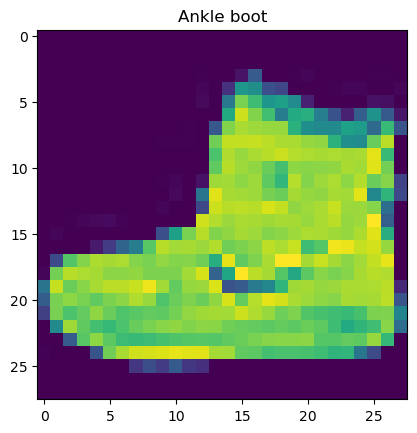

In [20]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.title(class_names[label])
plt.imshow(image.squeeze())

(-0.5, 27.5, 27.5, -0.5)

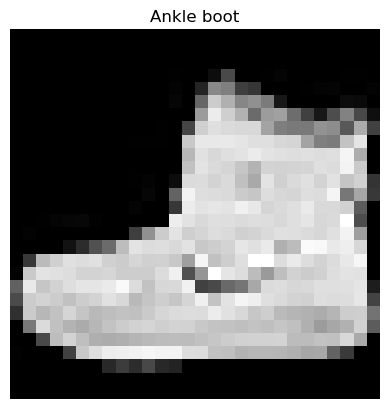

In [21]:
#gray mapping images
plt.imshow(image.squeeze(),cmap = 'gray')
plt.title(class_names[label])
plt.axis("off")

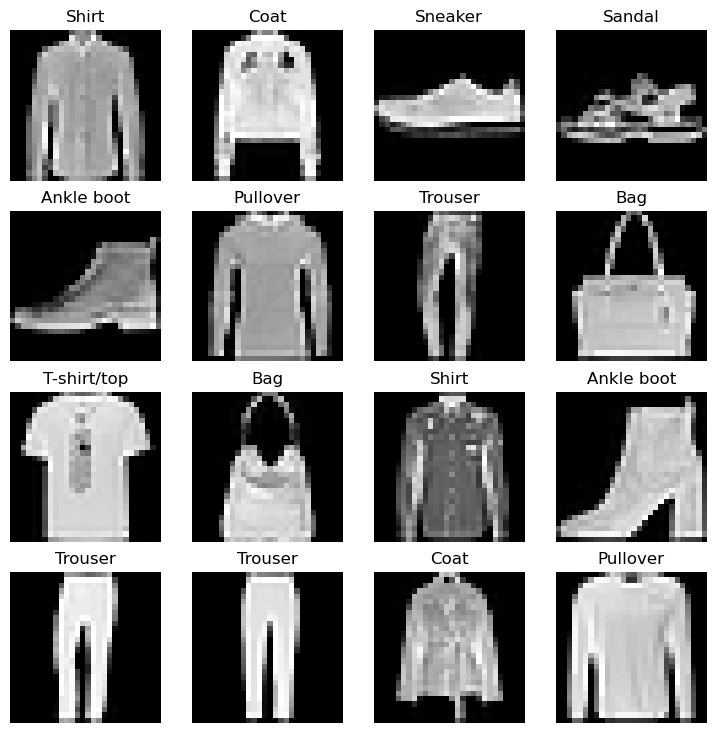

In [23]:
#torch.manual_seed(42)

fig = plt.figure(figsize = (9,9))
rows ,cols = 4,4
for i in range(1, rows*cols +1):
    random_idx = torch.randint(0,len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(),cmap = 'gray')
    plt.title(class_names[label])
    plt.axis(False);
    
    

In [23]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

# `Prepare DataLoader` (Train and Test Data)

Right now, our data is in the from of PyTorch Datasets

DataLoader turns our dataset into a PyTorch iterable

More specifically, we want to turn our data into batches(mini batches)



In [24]:
from torch.utils.data.dataloader import DataLoader

#batch size
BATCH_SIZE = 32

#turn datasets into iterable(batches)
train_dataloader = DataLoader(dataset = train_data,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x12df55d90>,
 <torch.utils.data.dataloader.DataLoader at 0x12e154510>)

In [25]:
#check out the status 

print(f" DataLoaders: {train_dataloader,test_dataloader}")
print(f" Length of train dataloader : {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f" Length of test dataloader : {len(test_dataloader)} batches of {BATCH_SIZE}")

 DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x12df55d90>, <torch.utils.data.dataloader.DataLoader object at 0x12e154510>)
 Length of train dataloader : 1875 batches of 32
 Length of test dataloader : 313 batches of 32


In [26]:
#check out what's inside of the train_DataLoader
train_dataloader.batch_sampler

In [27]:
#check out what's inside the train dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape #train_labels_batch represents the associted number of target values inside of a batch

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [28]:
train_labels_batch.unique()


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [29]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [30]:
type(train_features_batch)

torch.Tensor

In [31]:
print(train_features_batch.squeeze())

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [32]:
len(train_features_batch)

32

The representation of 14th image 


(-0.5, 27.5, 27.5, -0.5)

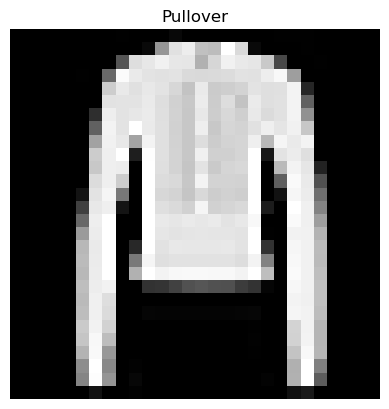

In [33]:
#show a sample of a particular batch

random_idx = torch.randint(0,len(train_features_batch),size =[1]).item()
image, label = train_features_batch[random_idx],train_labels_batch[random_idx]

#got the image and the associated label
print(f"The representation of {random_idx}th image ")
plt.imshow(image.squeeze(),cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)


## Baseline Model with two Linear Layers

when starting to build a series of ML modelling experiments, it's best practice to start with a baseline model. 

A baseline model is a simple model you willl try and improve upon with subsequent models/experiments. 

In other words: Start simply and add complexity when necessary

In [34]:
# Create a flatten layer
flatten_model = nn.Flatten()

#get a single sample
x = train_features_batch[0]

#flatten the sample
output = flatten_model(x) # performs the forward pass

#print out what happened
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [35]:
x.squeeze(), output.squeeze()

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000,

In [37]:
a = torch.rand((2,3,3)) #-->#height, length, width
a,a.shape

(tensor([[[0.7568, 0.7355, 0.2957],
          [0.9998, 0.3690, 0.5188],
          [0.2093, 0.1423, 0.5782]],
 
         [[0.4981, 0.5210, 0.2021],
          [0.7203, 0.2052, 0.0930],
          [0.7758, 0.7395, 0.8184]]]),
 torch.Size([2, 3, 3]))

In [39]:
flat_a = flatten_model(a) #--> #height, length*width
flat_a,flat_a.shape

(tensor([[0.7568, 0.7355, 0.2957, 0.9998, 0.3690, 0.5188, 0.2093, 0.1423, 0.5782],
         [0.4981, 0.5210, 0.2021, 0.7203, 0.2052, 0.0930, 0.7758, 0.7395, 0.8184]]),
 torch.Size([2, 9]))

In [40]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int, 
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                     out_features= hidden_units),
            nn.Linear(in_features = hidden_units,
                     out_features = output_shape)
        )


    def forward(self, x):
        return self.layer_stack(x)
    

In [43]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(
    input_shape=784, # this is 28*28
    hidden_units = 10, 
    output_shape = len(class_names)
)

model_0.to(device)

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [42]:
#device agnostic code
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

# Loss Function and Optimizer
* `Loss Function` - nn.CrossEntropyLoss()
*  `optimizer` - torch.optim.SGD
*  `Evaluation Matrix` - Accuracy

In [44]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                           lr = 0.01)

from torchmetrics import Accuracy
acc_fn = Accuracy(task = 'Multiclass',
                  num_classes = 10
                 ).to(device)
acc_fn

MulticlassAccuracy()

In [45]:
#download the py file
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download ....")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
        print("download Complete")
        

helper_functions.py already exists, skipping download ....


In [46]:
from helper_functions import accuracy_fn

In [47]:
accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

## Creating a funtion to time our experiments

Machine learning is very experimental

2 of the main things you'll often want to track are:
1. Model's performance
2. How fast it runs

In [48]:
from timeit import default_timer as timer
def print_train_time(start: float,
                    end: float,
                    device: torch.device = None):

    """Prints difference between start and end time. """
    total_time = end-start
    print(f"Train time on {device}: {total_time} seconds")
    return total_time

In [49]:
start_time = timer()
#some code
end_time = timer()
total_time = print_train_time(start_time,end_time,device = device)

Train time on mps: 2.4542008759453893e-05 seconds


In [50]:
start_time = timer()
#some code
end_time = timer()
total_time = print_train_time(start_time,end_time,device = "cpu")

Train time on cpu: 2.5415996788069606e-05 seconds


## Building Training and Testing Loop
Highlight that the `optimizer` will update a model's `parameters` once `per batch` rather than once per epoch........

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through test batches, perform testing steps , calculate the test loss per batch
4. Print out what's happening
5. Time it all(for run)

In [51]:
model_0.to('cpu')
from tqdm.auto import tqdm
#set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

#set the number of epochs
epochs = 3

#create e training and test loop

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n......")

    #Training
    train_loss = 0 #instantiate the training loss

    #calculate the training loss per batch

    # Per epoch calculate the loss of the total train datasets;

    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader): # X --> image(features), y--> target label
        model_0.train()

        # 1. forward pass
        y_pred = model_0(X) # X represents a full batch of image in our train dataloader

        # 2. Loss calculation
        loss = loss_fn(y_pred, y) #loss --> loss per batch
        train_loss +=loss # Accumulate train loss # train_loss --> Total loss 

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        #we are updating our model's parameters once per batch rather than waiting for it to see the whole dataset with every batch
 

        # Print out what's happening
        
        if batch %400 == 0:
            print(f" Looked at {batch * len(X)}/ {len(train_dataloader.dataset)} samples.")
        

    # Divide total train loss by length of train dataloader
    train_loss /=len(train_dataloader)



    ### Testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:

           # 1. Forward pass
            test_pred = model_0(X_test) # X_test batch in dataloader

            # 2. Calculate the loss accumulatively
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim =1))
        
        # Calculate the test loss avg per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)


    # Print out what's happening
    print(f" \nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_gpu,
                                           end = train_time_end_on_cpu,
                                           device = str(next(model_0.parameters()).device))

            
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
......
 Looked at 0/ 60000 samples.
 Looked at 12800/ 60000 samples.
 Looked at 25600/ 60000 samples.
 Looked at 38400/ 60000 samples.
 Looked at 51200/ 60000 samples.
 
Train loss: 0.9096 | Test loss: 0.6290 | Test acc: 78.6342
Epoch: 1
......
 Looked at 0/ 60000 samples.
 Looked at 12800/ 60000 samples.
 Looked at 25600/ 60000 samples.
 Looked at 38400/ 60000 samples.
 Looked at 51200/ 60000 samples.
 
Train loss: 0.5573 | Test loss: 0.5441 | Test acc: 81.1302
Epoch: 2
......
 Looked at 0/ 60000 samples.
 Looked at 12800/ 60000 samples.
 Looked at 25600/ 60000 samples.
 Looked at 38400/ 60000 samples.
 Looked at 51200/ 60000 samples.
 
Train loss: 0.5027 | Test loss: 0.5137 | Test acc: 81.9988
Train time on cpu: 6.611147416988388 seconds


# Make predictions and get Model 0 results

In [68]:
def eval_mode(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn):
    """Returns a dictionary containing the results of model predicting the data loader"""
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                              y_pred = y_pred.argmax(dim=1))

        #scale loss and acc to find the average loss/acc per batch
    loss=loss /len(data_loader)
    acc  = acc/ len(data_loader)


    return {"model_name": model.__class__.__name__,
           "model_loss": loss.item(),
           "model_acc":acc}
            
    #calculate model_0 results on test dataset
model_0_results  = eval_mode(model= model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

model_0_results
    

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5136752128601074,
 'model_acc': 81.9988019169329}

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5136752128601074,
 'model_acc': 81.9988019169329}

In [69]:
device

'mps'

In [95]:
for X_train, y_train in train_dataloader:
    image = X_train
    label = y_train
image.shape, label.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [96]:
for batch, (X_t,y_t) in enumerate(train_dataloader):
    print(batch)
    print(X_t.shape)
    print(y_t.shape)

0
torch.Size([32, 1, 28, 28])
torch.Size([32])
1
torch.Size([32, 1, 28, 28])
torch.Size([32])
2
torch.Size([32, 1, 28, 28])
torch.Size([32])
3
torch.Size([32, 1, 28, 28])
torch.Size([32])
4
torch.Size([32, 1, 28, 28])
torch.Size([32])
5
torch.Size([32, 1, 28, 28])
torch.Size([32])
6
torch.Size([32, 1, 28, 28])
torch.Size([32])
7
torch.Size([32, 1, 28, 28])
torch.Size([32])
8
torch.Size([32, 1, 28, 28])
torch.Size([32])
9
torch.Size([32, 1, 28, 28])
torch.Size([32])
10
torch.Size([32, 1, 28, 28])
torch.Size([32])
11
torch.Size([32, 1, 28, 28])
torch.Size([32])
12
torch.Size([32, 1, 28, 28])
torch.Size([32])
13
torch.Size([32, 1, 28, 28])
torch.Size([32])
14
torch.Size([32, 1, 28, 28])
torch.Size([32])
15
torch.Size([32, 1, 28, 28])
torch.Size([32])
16
torch.Size([32, 1, 28, 28])
torch.Size([32])
17
torch.Size([32, 1, 28, 28])
torch.Size([32])
18
torch.Size([32, 1, 28, 28])
torch.Size([32])
19
torch.Size([32, 1, 28, 28])
torch.Size([32])
20
torch.Size([32, 1, 28, 28])
torch.Size([32])
21

In [2]:
#create a person class
class Person():
    def __init__(self,name,age,height,occupation):
        self.name = name
        self.age = age
        self.height = height
        self.occupation = occupation
    def bmi_calculation(self):
        return self.height/self.age

In [3]:
p1 = Person('tinon',26,168,'student')
p2 = Person('tripto',20,148,'service holder')

In [4]:
p1.name

'tinon'

In [5]:
p1.bmi_calculation()

6.461538461538462

In [6]:
p2.bmi_calculation()

7.4

In [7]:
p2.occupation

'service holder'

In [18]:
class Employee(Person):
    def __init__(self,salary,job_description):
        super().__init__('t',42,145,'service holder')
        self.salary = salary
        self.job_description = job_description
    def retirement(self):
        if self.age>60:
            print('time to retirement')
        else:
            print('kaj kore kha')

In [20]:
employee1 = Employee(70,'programmer')

In [21]:
employee1.retirement()

kaj kore kha


In [22]:
help(Employee)

Help on class Employee in module __main__:

class Employee(Person)
 |  Employee(salary, job_description)
 |  
 |  Method resolution order:
 |      Employee
 |      Person
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, salary, job_description)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  retirement(self)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Person:
 |  
 |  bmi_calculation(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from Person:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

